In [48]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!python --version

Python 3.10.15


In [49]:
tf.__version__

'2.12.1'

In [51]:
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
IMG_SIZE = 224

In [52]:
def produce_dataset(num_classes):
    images_set = []
    labels = []
    for i in range(num_classes):
        data_path = os.path.join("data", f"{str(i)}")
        for images in os.listdir(data_path):
            img = cv2.imread(os.path.join(data_path, images))
            faces = face_cascade.detectMultiScale(img, 1.3, 5)
            for (x, y, w, h) in faces:
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
                images_set.append(resized_array)
                labels.append(i+1)


    print("Length of dataset: ", len(images_set))
    print("Length of dataset: ", len(labels))
    return images_set, labels

In [53]:
num_of_classes = 5
X, y = produce_dataset(num_of_classes) 

Length of dataset:  891
Length of dataset:  891


In [12]:
'''samp_ind = np.random.randint(0,480)
plt.imshow(X[samp_ind])
y[samp_ind]'''

'samp_ind = np.random.randint(0,480)\nplt.imshow(X[samp_ind])\ny[samp_ind]'

In [54]:
X = np.array(X)
X.shape

(891, 224, 224, 3)

In [55]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)
print (y.shape)

(891, 5)


In [9]:
y = np.array(y)
print(len(y))

775


In [56]:
from sklearn.model_selection import train_test_split
test_size = 0.10

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print ("train images",len(X_train))
print("Validation images: ", len(X_val))
print ("test_images ",len(X_test))

train images 623
Validation images:  134
test_images  134


In [16]:
from sklearn import preprocessing

test_images = np.array(X_test)

min_max_scaler = preprocessing.MinMaxScaler()
X_test_minmax = min_max_scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
print (len(X_test_minmax)) 

117


In [57]:
X_test = X_test / 255.0

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
            rescale=1./255,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True, 
            rotation_range=15,
            fill_mode = 'nearest')


datagen_val = ImageDataGenerator(rescale=1./255)

batch_size = 16

train_generator = datagen.flow(X_train, 
                               y_train, 
                               batch_size=batch_size,
                               shuffle=True
                               )

validation_generator = datagen_val.flow(X_val,
                                        y_val,
                                       batch_size = batch_size,
                                       shuffle = True)

print ("train images generator",len(train_generator))
print("Validation images generator:", len(validation_generator))

train images generator 39
Validation images generator: 9


In [59]:
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV3Small
import tensorflow_model_optimization as tfmot

In [60]:
mobilenet_model = MobileNetV3Small(
    input_shape = (224, 224, 3),
    alpha=1.0,
    #minimalistic=False,
    include_top=False,
    weights="imagenet",
    #dropout_rate=0.2,
    #classifier_activation="softmax",
    include_preprocessing=False,
)

for layers in mobilenet_model.layers:
    layers.trainable = False

In [63]:
def build_model(bottom_model, num_class):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    ## top_model = Dense(1024,activation='relu')(top_model)
    ## top_model = Dropout(0.15)(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    ## top_model = Dropout(0.1)(top_model)
    top_model = Dense(64,activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.05)(top_model)
    top_model = Dense(16,activation='relu')(top_model)
    top_model = Dense(num_class,activation='softmax')(top_model)

    # top_model = tfmot.sparsity.keras.prune_low_magnitude(GlobalAveragePooling2D())(top_model)
    # top_model = tfmot.sparsity.keras.prune_low_magnitude(Dense(128, activation='relu'))(top_model)
    # top_model = BatchNormalization()(top_model)  # BatchNorm is prunable but not wrapped
    # top_model = Dropout(0.05)(top_model)         # Dropout is ignored during pruning
    # top_model = tfmot.sparsity.keras.prune_low_magnitude(Dense(16, activation='relu'))(top_model)
    # output_layer = tfmot.sparsity.keras.prune_low_magnitude(Dense(num_class, activation='softmax'))(top_model)

    return Model(inputs=bottom_model.input, outputs=top_model)

In [69]:
model = build_model(mobilenet_model, num_of_classes)

In [70]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 112, 112, 16  64         ['Conv[0][0]']                   
 tion)                          )                                                           

In [71]:
optimizer1 = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name='Adam',
)

#loss="categorical_crossentropy" -> alculates the difference between the true labels and the predicted probability distribution for each class.
#                                -> Penalises the model more heavily when it assigns more probablity to the correct class
model.compile(loss="categorical_crossentropy",
              optimizer= optimizer1,
              metrics=["accuracy"])

In [72]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow_model_optimization.sparsity.keras import UpdatePruningStep

checkpoint = ModelCheckpoint("FRRP.keras",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

pruning_callback = UpdatePruningStep()


earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint, pruning_callback]

In [73]:
import time

start = time.time()
epochs = 20
#train_generator = train_generator.repeat()

history = model.fit(train_generator, 
                    batch_size = batch_size,
                    epochs=epochs,  
                    callbacks = callbacks,
                    shuffle = True,
                    validation_data= validation_generator)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/20
39/39 [==============================] - ETA: 0s - loss: 0.8473 - accuracy: 0.6870
Epoch 1: val_loss improved from inf to 1.09083, saving model to FRRP.keras
39/39 [==============================] - 17s 263ms/step - loss: 0.8473 - accuracy: 0.6870 - val_loss: 1.0908 - val_accuracy: 0.5373
Epoch 2/20
39/39 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.9695
Epoch 2: val_loss improved from 1.09083 to 0.48919, saving model to FRRP.keras
39/39 [==============================] - 9s 223ms/step - loss: 0.2418 - accuracy: 0.9695 - val_loss: 0.4892 - val_accuracy: 0.9478
Epoch 3/20
39/39 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.9904
Epoch 3: val_loss improved from 0.48919 to 0.20431, saving model to FRRP.keras
39/39 [==============================] - 9s 232ms/step - loss: 0.0900 - accuracy: 0.9904 - val_loss: 0.2043 - val_accuracy: 0.9776
Epoch 4/20
39/39 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.98

In [87]:
model.save("RP.keras")

In [74]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test accuracy :', test_accuracy)
print('Test loss :', test_loss)

print('Model accuracy is %.2f%% and Loss accuracy is %.2f%%' % (test_accuracy, test_loss))

5/5 [==============================] - 1s 218ms/step - loss: 3.1309e-04 - accuracy: 1.0000
Test accuracy : 1.0
Test loss : 0.000313090393319726
Model accuracy is 1.00% and Loss accuracy is 0.00%


In [35]:
from keras.models import load_model

model_prev = load_model('face_recogV3_final_small.keras')

In [75]:
model_prev.summary()

NameError: name 'model_prev' is not defined

In [76]:
data_dict = {"[0]": "Grandma",
             "[1]": "Harshanth",
             "[2]": "Lokesh",
             "[3]": "Surya",
             "[4]": "Nick"}

data_dict_n = {"0": "Grandma",
              "1": "Harshanth",
              "2": "Lokesh",
              "3": "Surya",
              "4": "Nick"}

In [77]:
def draw_test(name, pred, im):
    facial = data_dict[str(pred)]
    BLACK = [0,0,0]
    #expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    #expanded_image_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #cv2.putText(expanded_image, facial, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    #cv2.imshow(name, expanded_image)
    plt.imshow(im)
    plt.axis('off')
    plt.text(20, 60, facial, fontsize=20, color='red', bbox=dict(facecolor='white', alpha=0.5))
    plt.title(name)
    plt.show()

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + data_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name), path_class

In [78]:
sample_count = 20
wrong=0
for i in range(0, sample_count):
    input_im, path_class = getRandomImage("data/")
    if input_im.shape[0] != 224 and input_im.shape[1] != 224:
        continue
    
    input_original = input_im.copy()
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(model.predict(input_im, 1, verbose = 0), axis=1)
    
    if(data_dict_n[str(path_class)] != data_dict[str(res)]):
        print("Wrong prediction Class")
        wrong+=1
    
    # Show image with predicted class
    #draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

print("Total Wrong ones: {}\nTotal correct ones: {}".format(wrong, sample_count-wrong))

cv2.destroyAllWindows()

Class - Harshanth
Class - Surya
Class - Harshanth
Class - Nick
Class - Grandma
Class - Grandma
Class - Grandma
Class - Grandma
Class - Surya
Class - Nick
Class - Lokesh
Class - Nick
Class - Nick
Class - Nick
Class - Lokesh
Class - Lokesh
Class - Grandma
Class - Harshanth
Class - Surya
Class - Surya
Total Wrong ones: 0
Total correct ones: 20


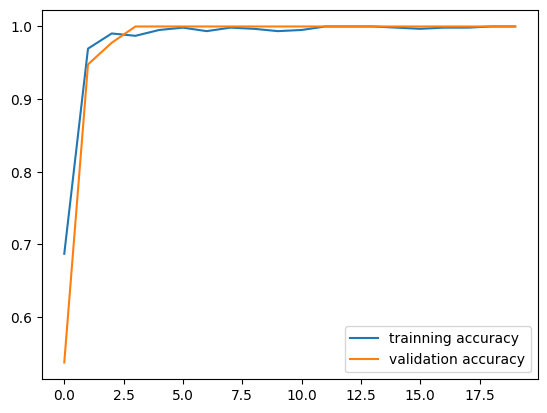

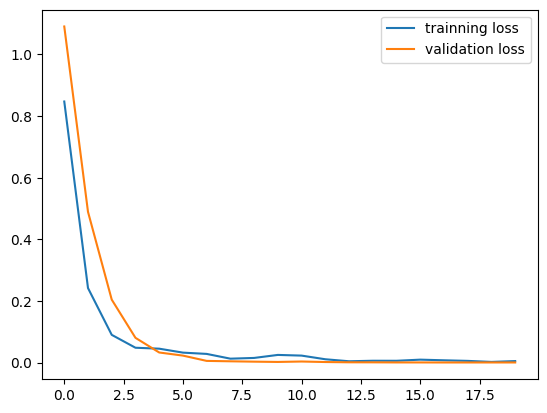

In [79]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_accuracy))

plt.plot(epochs, train_accuracy, label="trainning accuracy")
plt.plot(epochs, val_accuracy, label="validation accuracy")

plt.legend()
plt.show()

plt.plot(epochs, train_loss, label="trainning loss")
plt.plot(epochs, val_loss, label="validation loss")
plt.legend()
plt.show()

In [80]:
prediction_model= model.predict(X_test, verbose=1)

prediction_classes_model = np.argmax(prediction_model, axis=1)
test_labels_prediction= np.argmax(y_test, axis=1)

5/5 [==============================] - 3s 222ms/step


In [81]:
from sklearn.metrics import confusion_matrix


#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(test_labels_prediction, prediction_classes_model)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

#Plotting the confusion matrix
confusion_mtx=confusion_matrix(test_labels_prediction, prediction_classes_model)


In [86]:
model.save('FEEER.keras')

In [84]:
labels_classes = ['Grandma', 'harsh', 'Lokesh', 'Surya', 'Nick']

In [85]:
from sklearn.metrics import classification_report

print(classification_report(test_labels_prediction, prediction_classes_model, target_names=labels_classes))

              precision    recall  f1-score   support

     Grandma       1.00      1.00      1.00        30
       harsh       1.00      1.00      1.00        34
      Lokesh       1.00      1.00      1.00        34
       Surya       1.00      1.00      1.00        13
        Nick       1.00      1.00      1.00        23

    accuracy                           1.00       134
   macro avg       1.00      1.00      1.00       134
weighted avg       1.00      1.00      1.00       134



## Model Optimization

In [66]:
def get_model_size(file_path):
    return os.path.getsize(file_path) / 1e6

In [67]:
get_model_size('face_recogV3_final_final.keras')

5.993952

In [68]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
pruned_model = strip_pruning(model)

In [70]:
pruned_model.save('face_recog_prunes.keras', include_optimizer=False)
pruned_model.save('face_recog_prunes.h5',include_optimizer=False)

## Prund model metrics evaluation

In [71]:
sample_count = 20
wrong=0
for i in range(0, sample_count):
    input_im, path_class = getRandomImage("data/")
    if input_im.shape[0] != 224 and input_im.shape[1] != 224:
        continue
    
    input_original = input_im.copy()
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(pruned_model.predict(input_im, 1, verbose = 0), axis=1)
    
    if(data_dict_n[str(path_class)] != data_dict[str(res)]):
        print("Wrong prediction Class")
        wrong+=1
    
    # Show image with predicted class
    #draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

print("Total Wrong ones: {}\nTotal correct ones: {}".format(wrong, sample_count-wrong))

cv2.destroyAllWindows()

Class - Grandma
Class - Surya
Class - Lokesh
Class - Harshanth
Class - Lokesh
Class - Harshanth
Class - Grandma
Class - Harshanth
Class - Surya
Class - Surya
Class - Lokesh
Class - Surya
Wrong prediction Class
Class - Lokesh
Class - Surya
Class - Grandma
Class - Surya
Class - Lokesh
Class - Grandma
Class - Lokesh
Class - Surya
Total Wrong ones: 1
Total correct ones: 19


In [72]:
import numpy as np

def low_rank_factorization(weights, rank):
    """Perform low-rank factorization on weight matrices using SVD."""
    U, S, Vt = np.linalg.svd(weights, full_matrices=False)
    S = np.diag(S)
    
    # Approximate W as A (U * S) and B (Vt)
    A = np.dot(U, np.sqrt(S))[:, :rank]
    B = np.dot(np.sqrt(S), Vt)[:rank, :]
    return A, B

In [73]:
for layer in pruned_model.layers:
    if isinstance(layer, Dense):
        weights, biases = layer.get_weights()
        A, B = low_rank_factorization(weights, rank=64)  # Choose a rank smaller than original dimensions
        layer.set_weights([np.dot(A, B), biases])  # Replace weights with factorized approximation


In [75]:
pruned_model.save("fFR_prune_LRF.keras", include_optimizer=False)